# Neural network with integrate and fire neurons

[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/subhacom/moose-notebooks/blob/main/Leaky_integrate_and_fire_neuron.ipynb) 

If you are using `colab`, in a fresh runtime you need to run pip to install pymoose there. On the other hand, if you are running jupyter locally and have pymoose installed in that environment, skip the line below.

In [1]:
# Only required on colab!
# !pip install pymoose --quiet


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


We have already seen Hodgkin-Huxley's model of spiking in the squid giant axon. This is a rather complex model. Researchers often simplify the spiking neuron as an [integrate and fire](https://neuronaldynamics.epfl.ch/online/Ch1.S3.html) (IF) neuron.

In the exercise 3 in the [Synapses](./Synapses.ipynb) notebook you may have noticed that when two spikes arrive at the synapse close together in time, their effects add up. When spikes arrive simultaneously at multiple synapses, their effect also add up similarly. When the EPSP goes above the threshold for spiking, the neuron generates a spike. To mimic this, we can have a neuron model which adds up its input, and fires an action potential whenever the voltage goes above threshold. A simple version of this abstraction was developed by [Warren McCulloch](https://en.wikipedia.org/wiki/Warren_Sturgis_McCulloch) and [Walter Pitts](https://en.wikipedia.org/wiki/Walter_Pitts), called [perceptron](https://en.wikipedia.org/wiki/Perceptron) or McCulloch-Pitts neuron, forms the foundation of Artificial Neural Networks (ANN).

The integrate and fire model tries to to mimic the biophysics of the neuron in more detail. It implements this by adding the inputs to the present membrane voltage which keeps decaying with a time constant (RC circuit). When the voltage crosses the threshold, the neuron generates a spike and its voltage is reset to a small value. Also, neurons need some minimum time to recover after a spike, which is called refractory period. Once an IF neuron spikes, it cannot fire another spike within this time. There are many variations of the integrate and fire model, and in what we describe above, the decay represents leakage of the current through the RC circuit, and hence it is called Leaky Integrate and Fire (LIF) model. In moose this is implemented by the class `IntFire`.

The LIF model can be described mathematically as

$C_{m} \frac{dV_{m}(t)}{dt} = I(t) - \frac{V_{m}(t)}{R_{m}}$

or $\frac{dV_{m}(t)}{dt} = \frac{I(t)}{C_{m}} - \frac{V_{m}(t)}{R_{m} C_{m}}$

or $\frac{dV_{m}(t)}{dt} = activation - \frac{V_{m}(t)}{\tau_{m}}$

where $activation$ is $\frac{I(t)}{C_{m}}$, a value proportional to the total input synaptic current, and $\tau_{m} = R_{m} C_{m}$.

Additionally, the firing time is

$t^{(f)}: V_{m}(t) = threshold$ 

if $t - t^{(f)}_{last}> t_{r}$ where $t_{r}$ is the refractory period and $t^{(f)}_{last}$ is the time of last firing.

And right after the firing event, the voltage is reset to a fixed value:

$\lim_{\delta \to 0+} V_{m}(t^{(f)} + \delta) = V_{reset}$



## We shall implement a network of LIF neurons in MOOSE step by step below

In [2]:
# imports

import numpy as np
import matplotlib.pyplot as plt

import moose


In [3]:
# containers
if moose.exists('/sim'):
    moose.delete('/sim')
    
sim = moose.Neutral('/sim')
model = moose.Neutral(f'{sim.path}/model')
data = moose.Neutral(f'{sim.path}/data')

## Creating a single integrate and fire neuron with random input

The `LIF` class in MOOSE implements a simple leaky integrate and fire neuron. Like `Compartment`, it has a `Vm` field which is an abstraction of the membrane voltage of a real neuron. Below we create a single IF neuron called `neuronA` and attach a table `vmA` to record its `Vm`.

In [4]:
# Create a simple integrate and fire neuron
neuronA = moose.LIF(f'{model.path}/neuronA')

In [5]:
vmA = moose.Table(f'{data.path}/VmA')
moose.connect(vmA, 'requestOut', neuronA, 'getVm')

<moose.SingleMsg id=5 dataIndex=0 path=/Msgs[0]/singleMsg[0]>

Next, we create a `SimpleSynHandler` object to handle incoming spikes and pass the activation to the IG neuron.

In [6]:
# Handler for synaptic input
synh = moose.SimpleSynHandler(f'{neuronA.path}/synh')
synh.numSynapses = 1   # for a starter have just one synapse

In [7]:
# Connect the activation output of the SynHandler to the activation input of the IntFire neuron
moose.connect(synh, 'activationOut', neuronA, 'activation')

<moose.SingleMsg id=5 dataIndex=1 path=/Msgs[0]/singleMsg[1]>

### Add a random spike input to the synapse

For generating spikes, we shall use a random spike generator (`RandSpike`) in this test. A `RandSpike` generates spikes at random times at a specified rate. Thus, the probability of a spike in $dt$ time interval is $rate * dt$. This also has a refractory period, `refractT`, and after generating a spike it will not produce a second spike with that time, irrespective of $rate$ and $dt$.

In [8]:
# Create and connect a spike generator to deliver spike events to the `SynChan`
spikegen = moose.RandSpike(f'{model.path}/spike')
moose.connect(spikegen, 'spikeOut', synh.synapse[0], 'addSpike')

<moose.SingleMsg id=5 dataIndex=2 path=/Msgs[0]/singleMsg[2]>

### Setup recording of the spike times of the random spike generator
To relate the input and output, we can use a `Table` to record the spike times from the `RandSpike`. The latter sends out a message `spikeOut` with spike time upon each spike event. These discontinuous outputs can be caputured in the `input` field of the `Table.

In [9]:
itab = moose.Table(f'{data.path}/ispike')
moose.connect(spikegen, 'spikeOut', itab, 'input')

<moose.SingleMsg id=5 dataIndex=3 path=/Msgs[0]/singleMsg[3]>

### Set the properties of the model components
*Note: You can modify the code below and rerun the three cells (reinit, start and plot) repeatedly with no problem. However, you should not rerun the code above because that will change the structure of the model (particularly the `connect` statements) and can incorrect results. If you want to modify the structure of the model, restart the kernel and run from the beginning of the notebook.*

In [10]:
# prevent the spikegen from generating spikes at intervals shorter than 5 ms.
spikegen.refractT = 5e-3 
spikegen.rate = 100    # 100 Hz rate

neuronA.thresh = 10e-3  # firing threshold

# LIF computes time constant as tau = Cm * Rm
neuronA.Cm = 1.0    
neuronA.Rm = 1e-3   # time constant for voltage decay
neuronA.refractoryPeriod = 0.0

synh.synapse[0].weight = 1.0
synh.synapse[0].delay = 0

In [11]:
runtime = 200e-3

moose.seed(0)
moose.reinit()
moose.start(runtime)

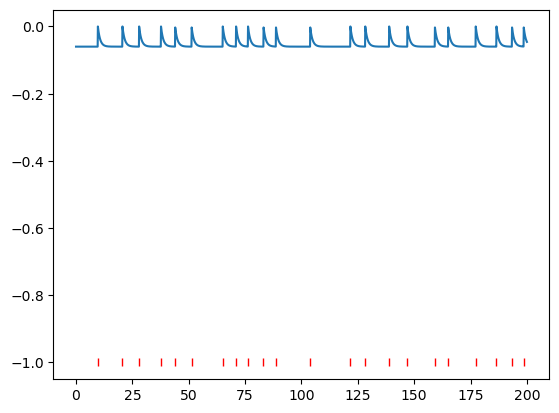

In [12]:
t = np.arange(len(vmA.vector)) * vmA.dt
plt.plot(t * 1e3, vmA.vector)
# the following plots the time points in itab as red vertical bars ('r|')
plt.plot(itab.vector * 1e3, [-1] * len(itab.vector), 'r|')  

An input spike (red bars) evoked a spike in the LIF neuron most of the time. By changing the synaptic weight and the rate of the `RandSpike` you can investigate the integrating behavior of the neuron more closely. 

## Exercise
1. Modify the `rate` attribute of the `RandSpike` object. What is do you observe?
2. Set the `refractoryPeriod` of the LIF neuron (`neuronA`) to a value like 5 ms and rerun the simulation. What do you observe?

## Multiple synaptic connections to a single LIF neuron
A single `SynHandler` can handle multiple synaptic connections in parallel. The number of synapses can be set by `SynHandler.synapse.num` field (this notation means `SynHandler` has an attribute called `synapse`, which has an attribute called `num` - the number of allowed synaptic connections).

Below we set this to 2. Then we create two `RandomSpike` object and connect them to these entries in the `synapse`.

We delete the existing container to start with a clean slate. Once connections are setup and the model is initialized (by calling `moose.reinit` like above), modifying it is error-prone. So we start with replicating the initial setup code from above. The first `if` block ensures that we delete the container `/sim` only if it already exists.

**One common gotcha** *with Python and MOOSE is that in Python a variable persists until it goes out of scope. MOOSE objects, however, persist until you explicitly delete them using `moose.delete`. But the Python variable associated with the MOOSE object may continue to exist, and if you refer to such deleted objects, Python will crash*

In [13]:
# containers
if moose.exists('/sim'):
    moose.delete('/sim')
    
sim = moose.Neutral('/sim')
model = moose.Neutral(f'{sim.path}/model')
data = moose.Neutral(f'{sim.path}/data')

# Create a simple integrate and fire neuron
neuronA = moose.IntFire(f'{model.path}/neuronA')
# Handler for synaptic input
synh = moose.SimpleSynHandler(f'{neuronA.path}/synh')
# Connect the activation output of the SynHandler to the activation input of the IntFire neuron
moose.connect(synh, 'activationOut', neuronA, 'activation')

<moose.SingleMsg id=5 dataIndex=4 path=/Msgs[0]/singleMsg[4]>

### Create *two* random spike generators and connect them to the synapses
This is where the code becomes specific for two synapses

In [16]:
# Set the number of synapses to 2
synh.numSynapses = 2
# Create and connect two spike generator to deliver spike events to the `SynChan`.
# Note that index starts at 0.
spikegen1 = moose.RandSpike(f'{model.path}/spike1')
moose.connect(spikegen1, 'spikeOut', synh.synapse[0], 'addSpike')
spikegen2 = moose.RandSpike(f'{model.path}/spike2')
moose.connect(spikegen2, 'spikeOut', synh.synapse[1], 'addSpike')

<moose.SingleMsg id=5 dataIndex=6 path=/Msgs[0]/singleMsg[6]>

In [17]:
print(moose.le('/sim/model'))

Elements under /sim[0]/model[0]
    /sim[0]/model[0]/neuronA
    /sim[0]/model[0]/spike1
    /sim[0]/model[0]/spike2

['/sim[0]/model[0]/neuronA', '/sim[0]/model[0]/spike1', '/sim[0]/model[0]/spike2']


Next we set up two tables for recording the spike times from the two spike generators.

In [18]:
# Record Vm of the LIF neuron in vmA
vmA = moose.Table(f'{data.path}/VmA')
moose.connect(vmA, 'requestOut', neuronA, 'getVm')

# Record spike times of the first `RandomSpike` object in ispike1
itab1 = moose.Table(f'{data.path}/ispike1')
moose.connect(itab1, 'requestOut', spikegen1, 'getLastEventT')

# Record spike times of the second `RandomSpike` object in ispike2
itab2 = moose.Table(f'{data.path}/ispike2')
moose.connect(itab2, 'requestOut', spikegen2, 'getLastEventT')

<moose.SingleMsg id=5 dataIndex=9 path=/Msgs[0]/singleMsg[9]>

We can now set the properties of the spike generators, the neuron, and the synapses. Notice that each entry in the array of synapses managed by a `SynHandler` can have different `weight` and `delay`. 

Moreover, `RandSpike` can also generate periodic spikes instead of randomly timed spikes. To switch to this mode, set the `doPeriodic` field of a `RandSpike` object to `True`. Below we keep the first `RandSpike` random and make the second periodic.

In [19]:
spikegen1.refractT = 5e-3
spikegen1.rate = 100    # 100 Hz rate

spikegen2.refractT = 0
spikegen2.rate = 100   # 100 Hz rate
spikegen2.doPeriodic = True

# Set the properties of the LIF neuron
neuronA.thresh = 10e-3  # firing threshold
neuronA.tau = 1e-3   # time constant for voltage decay

# Set the properties of the two synapses 
synh.synapse[0].weight = 1.0
synh.synapse[0].delay = 0

synh.synapse[1].weight = 1.0
synh.synapse[1].delay = 0

Finally we initialize and run the simulation

In [20]:
runtime = 200e-3

moose.seed(0)
moose.reinit()
moose.start(runtime)

We can now plot the `Vm` of the LIF neuron along with the two input spike trains.

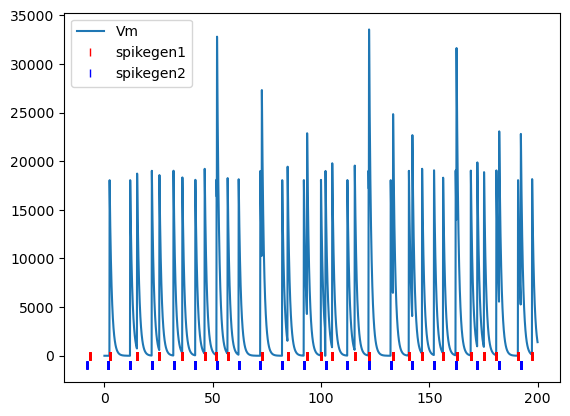

In [21]:
t = np.arange(len(vmA.vector)) * vmA.dt
plt.plot(t * 1e3, vmA.vector, label='Vm')
plt.plot(itab1.vector * 1e3, [-1] * len(itab1.vector), 'r|', label='spikegen1') 
plt.plot(itab2.vector * 1e3, [-1000] * len(itab2.vector), 'b|', label='spikegen2')
plt.legend()

Note that although setting `doPeriodic` to `True` makes the spikes generated by `RandSpike` regular, the time of the first spike is still random. In order to get deterministic spikes you can use a `PulseGen` object driving a `SpikeGen` object. Each time the `PulseGen` output (input to the `SpikeGen`) crosses the threshold of the of the `SpikeGen`, it will emit a spike.

# Exercises

1. Change the `weight` attribute of one of the neurons to a small negative value. What do you observe? What could be the effect of such synapses on the activity of a neuron?